# Using carbon-aware scheduling for crews

**Table of contents**
- Overview
- Setup
  - Get Token
- Utility Functions
    - Function to call API
    - Input format for API
    - Accepted input values
- Use Case Implementation
  - Fastest route
  - Shortest route
  - Comparison Between Routes
- Related Links

## Overview

APIs that are used in this sample: **IBM Environmental Intelligence - Greenhouse Gas (GHG) Emissions - Mobile Emissions API**

You can calculate the emissions produced based on the type of vehicle and the amount of fuel consumed on a particular route. This approach helps you to choose the most sustainable option for task completion, while balancing operational efficiency and environmental responsibility.

The U.S. Environmental Protection Agency calculates that the transportation sector generates the largest share, approximately 29%, of Greenhouse Gas Emissions. As a result, carbon-responsible enterprises are focusing on reducing transportation-related emissions where possible. A carbon-aware approach to crew scheduling has the potential to reduce the carbon footprint of an organization, while still fulfilling work orders.

**Business value**
- Reduction of carbon footprint
- Sustainable work order fulfillment

**Use Case**

Consider a scenario where a utility company needs to dispatch a crew for maintenance. We can evaluate a vehicle's emissions based on fuel usage, which can help to estimate the carbon impact of different routes. 

- **Shortest Route**: Minimizes the distance traveled, potentially reducing emissions.
- **Fastest Route**: Minimizes time spent on the road, which could lower emissions depending on traffic conditions and fuel efficiency at different speeds.

For more information on the inputs and output data points for the Mobile GHG Emissions API Endpoint, see [GHG Emissions API Developer Guide](https://developer.ibm.com/apis/catalog/envintelsuite--ibm-environmental-intelligence/GHG+Emissions+API).



![carbon_aware_crew_scheduling.png](carbon_aware_crew_scheduling.png)

## Setup

Ensure that Python is installed in your system. Python 3+ is required.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your credentials for GHG Emission APIs in a file named `secrets.ini` in the following format:

```
[EI]
api.api_key = <Your GHG APIs API key>
api.client_id = <Your GHG APIs client Id>
```

Keep the secrets.ini file at an appropriate relative location of this notebook, for example, as specified in this config:

```config.read('../../../auth/secrets.ini')```

In [59]:
# Install the packages below using pip/pip3 based on your python version.
# pip install pandas,configparser,json,IPython
import pandas as pd
import configparser
import requests
import json
from IPython.display import display as display_summary

In [60]:
import matplotlib.pyplot as plt

### Get token

Run the following code snippet to generate the Auth Bearer Token by using your api_key configured in secrets.ini.

In [61]:
config = configparser.RawConfigParser()
config.read(['../../../auth/secrets.ini','../../../auth/config.ini'])

EI_API_KEY  = config.get('EI', 'api.api_key')
EI_CLIENT_ID = config.get('EI', 'api.client_id')
EI_AUTH_ENPOINT = config.get('EI', 'api.auth_endpoint')
EI_BASE_URL = config.get('EI', 'api.base_url')

def get_bearer_token(token):
    headers = {
        'Content-Type': 'application/json',
        'cache-control': 'no-cache',
    }
    data = {"apiKey":token, "clientId":EI_CLIENT_ID}
    bearer_token_req = requests.post(EI_AUTH_ENPOINT, headers=headers, data= json.dumps(data))
    if bearer_token_req.status_code != 200:
        print( "Error in getting Bearer token. Error code : ",bearer_token_req.status_code)
    return bearer_token_req.json()['access_token']

mybearer_token = get_bearer_token(EI_API_KEY)

## Utility Functions

Let us setup utility helper functions to run this use case.

### Function to call API

In [62]:
def call_carbon_api(co2_api, co2_data, token):
    headers = {
        'accept': 'application/json',
        'Authorization': 'Bearer '+token,
        'Content-Type': 'application/json',
    }

    co2_response_req = requests.post( co2_api, headers=headers, data=json.dumps(co2_data))
    if co2_response_req.status_code != 200:
        print( "Problem! Error in generating response. Error code : ",co2_response_req.status_code)
    return co2_response_req.json()

### Input format for API

In [63]:
def customer_id(customer_id):
    Input =  {
              "id": customer_id
          }
    return Input 

def customer_on_behalf_of_client(company_id,company_name):
    Input =  {
              "companyId": company_id,
              "companyName": company_name
          }
    return Input  


def customer_organisation(department_id,department_name):
    Input =  {
              "departmentId": department_id,
              "departmentName": department_name
          }
    return Input  


def customer_request_type(request_type):
    return request_type     


def customer_location(country,state_province,zip_post_code,city):
    Input =  {
              "country": country,
              "stateProvince": state_province,
              "zipPostCode": zip_post_code,
              "city": city
          }
    return Input        


def customer_site(site_id,site_name,building_id,building_name):
    Input = {
              "siteId": site_id,
              "siteName": site_name,
              "buildingId": building_id,
              "buildingName": building_name
          }               
    return Input

def mobile_input(vehicle_type,fuel_used,fuel_amount,unit_of_fuel_amount):
    input = {"vehicleType": vehicle_type,
             "fuelUsed": fuel_used,
             "fuelAmount": fuel_amount,
             "unitOfFuelAmount": unit_of_fuel_amount
            }
    return input

### Accepted input values

You can check the accepted values for the individual fields of the request payload. For more information, see [GHG Emissions API Developer Guide](https://developer.ibm.com/apis/catalog/envintelsuite--ibm-environmental-intelligence/GHG+Emissions+API#mobile).

## Use Case Implementation

### Fastest route

Now, using the GHG Mobile Emissions APIs, calculate the emissions for the fastest route. 

In [64]:
fuel_consumed_fastest = '20' #in US gallon
time_fastest = '12' # hours

In [65]:
payload_fastest = {'customID'        : customer_id(customer_id='123'), 
                   'onBehalfOfClient': customer_on_behalf_of_client(company_id='111',
                                                                 company_name='XYZ') , 
                   'organisation'    : customer_organisation(department_id='345',
                                                             department_name='HR'), 
                   'requestType'     : customer_request_type(request_type='ACTUAL'), 
                   'location'        : customer_location(country='US',
                                                         state_province='New York',
                                                         zip_post_code='11430',
                                                         city='NYC'),
                   'site'            : customer_site(site_id='321',
                                                     site_name='PQR',
                                                     building_id='123',
                                                     building_name='ABC'), 
                   'timePeriod'      : {'year' : '2021', 
                                        'month': '10'},
                   'activityData' : mobile_input(
                                                    vehicle_type = "Light Goods Vehicle - Gasoline - year 2005-present",
                                                    fuel_used = "Gasoline",
                                                    fuel_amount = fuel_consumed_fastest,
                                                    unit_of_fuel_amount = "US Gallon"
                                                                             )
                   }        
       
print("The request payload is :",json.dumps(payload_fastest, indent=2))

The request payload is : {
  "customID": {
    "id": "123"
  },
  "onBehalfOfClient": {
    "companyId": "111",
    "companyName": "XYZ"
  },
  "organisation": {
    "departmentId": "345",
    "departmentName": "HR"
  },
  "requestType": "ACTUAL",
  "location": {
    "country": "US",
    "stateProvince": "New York",
    "zipPostCode": "11430",
    "city": "NYC"
  },
  "site": {
    "siteId": "321",
    "siteName": "PQR",
    "buildingId": "123",
    "buildingName": "ABC"
  },
  "timePeriod": {
    "year": "2021",
    "month": "10"
  },
  "activityData": {
    "vehicleType": "Light Goods Vehicle - Gasoline - year 2005-present",
    "fuelUsed": "Gasoline",
    "fuelAmount": "20",
    "unitOfFuelAmount": "US Gallon"
  }
}


In [66]:
EI_API_ENDPOINT = f"{EI_BASE_URL}/v2/carbon/mobile"
co2_response_fastest = call_carbon_api(EI_API_ENDPOINT , payload_fastest, mybearer_token)

df_res_fastest = pd.json_normalize(co2_response_fastest)
df_styled = df_res_fastest.style.set_table_styles([{
    'selector': 'table',
    'props' : [
        ('display', 'block'),
        ('overflow-x', 'auto'),
        ('white-space', 'nowrap')
    ]
}])
display_summary(df_styled)

,CH4,CO2e,N2O,biogenicCO2,description,fossilFuelCO2,unitOfMeasurement
0,0.000005,0.176635,0.000003,0.000000,"Fuel-use method is used. Emission factors are from Cross-Sector Tools Version 2, GHG Protocol. GWP values are obtained from IPCC Sixth Assessment Report, 2021 (AR6)",0.175600,metric tonne


### Shortest route

Using the GHG Mobile Emissions APIs, calculate the emissions for the shortest route.

In [67]:
fuel_consumed_shortest = '17.5' #in US gallon
time_shortest = '16' # hours

In [68]:
payload_shortest = {'customID'        : customer_id(customer_id='123'), 
                   'onBehalfOfClient': customer_on_behalf_of_client(company_id='111',
                                                                 company_name='XYZ') , 
                   'organisation'    : customer_organisation(department_id='345',
                                                             department_name='HR'), 
                   'requestType'     : customer_request_type(request_type='ACTUAL'), 
                   'location'        : customer_location(country='US',
                                                         state_province='New York',
                                                         zip_post_code='11430',
                                                         city='NYC'),
                   'site'            : customer_site(site_id='321',
                                                     site_name='PQR',
                                                     building_id='123',
                                                     building_name='ABC'), 
                   'timePeriod'      : {'year' : '2021', 
                                        'month': '10'},
                   'activityData' : mobile_input(
                                                    vehicle_type = "Light Goods Vehicle - Gasoline - year 2005-present",
                                                    fuel_used = "Gasoline",
                                                    fuel_amount = fuel_consumed_shortest,
                                                    unit_of_fuel_amount = "US Gallon"
                                                                             )
                   }        
       
print("Requests payload is :",json.dumps(payload_shortest, indent=2))

Requests payload is : {
  "customID": {
    "id": "123"
  },
  "onBehalfOfClient": {
    "companyId": "111",
    "companyName": "XYZ"
  },
  "organisation": {
    "departmentId": "345",
    "departmentName": "HR"
  },
  "requestType": "ACTUAL",
  "location": {
    "country": "US",
    "stateProvince": "New York",
    "zipPostCode": "11430",
    "city": "NYC"
  },
  "site": {
    "siteId": "321",
    "siteName": "PQR",
    "buildingId": "123",
    "buildingName": "ABC"
  },
  "timePeriod": {
    "year": "2021",
    "month": "10"
  },
  "activityData": {
    "vehicleType": "Light Goods Vehicle - Gasoline - year 2005-present",
    "fuelUsed": "Gasoline",
    "fuelAmount": "17.5",
    "unitOfFuelAmount": "US Gallon"
  }
}


In [69]:
EI_API_ENDPOINT = f"{EI_BASE_URL}/v2/carbon/mobile"

co2_response_shortest = call_carbon_api(EI_API_ENDPOINT , payload_shortest, mybearer_token)

df_res_shortest = pd.json_normalize(co2_response_shortest)
df_styled = df_res_shortest.style.set_table_styles([{
    'selector': 'table',
    'props' : [
        ('display', 'block'),
        ('overflow-x', 'auto'),
        ('white-space', 'nowrap')
    ]
}])
display_summary(df_styled)

,CH4,CO2e,N2O,biogenicCO2,description,fossilFuelCO2,unitOfMeasurement
0,0.000004,0.154556,0.000003,0.000000,"Fuel-use method is used. Emission factors are from Cross-Sector Tools Version 2, GHG Protocol. GWP values are obtained from IPCC Sixth Assessment Report, 2021 (AR6)",0.153650,metric tonne


### Comparison Between Routes

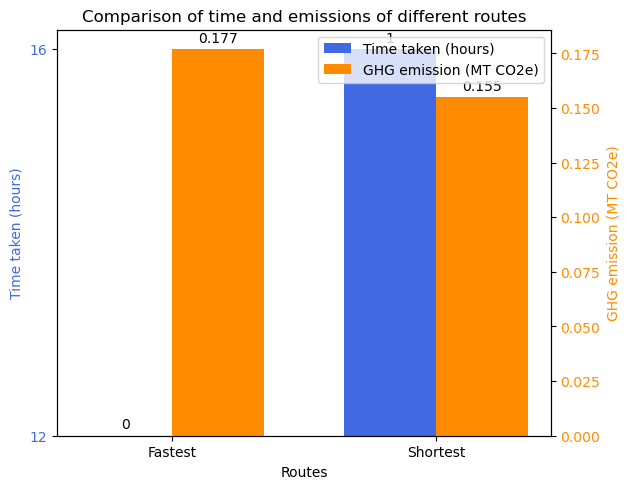

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
routes = ['Fastest', 'Shortest']
emission = [round(co2_response_fastest['CO2e'], 3), round(co2_response_shortest['CO2e'] ,3) ]  # Fuel consumed for each route
time_taken = [time_fastest, time_shortest]   # Time taken for each route

x = np.arange(len(routes))  # The label locations
width = 0.35  # The width of the bars

fig, ax1 = plt.subplots()

# Plotting the first set of bars for fuel consumed
rects1 = ax1.bar(x - width/2, time_taken, width, label='Time taken (hours)', color='royalblue')
ax1.set_xlabel('Routes')
ax1.set_ylabel('Time taken (hours)', color='royalblue')
ax1.set_xticks(x)
ax1.set_xticklabels(routes)
ax1.tick_params(axis='y', labelcolor='royalblue')

# Creating a second y-axis for time taken
ax2 = ax1.twinx()  
rects2 = ax2.bar(x + width/2, emission, width, label='GHG emission (MT CO2e)', color='darkorange')
ax2.set_ylabel('GHG emission (MT CO2e)', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Adding value labels on top of bars
ax1.bar_label(rects1, padding=3)
ax2.bar_label(rects2, padding=3)
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
fig.tight_layout()
plt.title('Comparison of time and emissions of different routes')
plt.show()


Calculating the GHG emissions for different crew schedule scenarios by using the GHG Mobile Emissions API helps you to quantify the emissions that are associated with different vehicle types and routes.  By using these insights, organizations can optimize routes and vehicle choices to minimize their carbon footprint, align with sustainability goals, and enhance overall decision-making processes. 

## Related Links

[GHG Emissions API Developer Guide](https://developer.ibm.com/apis/catalog/envintelsuite--ibm-environmental-intelligence/GHG+Emissions+API)